## Assignment 3
### Creating Composites of AVISO Altimetry Data


<div class="alert alert-block alert-info">
Import Necessary Modules
</div>

In [30]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

<div class="alert alert-block alert-info">
Read in Data
</div>

In [31]:
# Aviso Data
file_aviso = "/project/airsea/AVISO/1993_2015_15N-15S_AVISO_SLA_ADT.nc"
ds_aviso = xr.open_dataset(file_aviso)
ds_aviso

<xarray.Dataset>
Dimensions:    (latitude: 121, longitude: 1440, time: 8400)
Coordinates:
  * longitude  (longitude) float32 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * latitude   (latitude) float32 -14.88 -14.62 -14.38 ... 14.62 14.88 15.12
  * time       (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2015-12-31
Data variables:
    sla        (time, latitude, longitude) float64 ...
    adt        (time, latitude, longitude) float64 ...
Attributes: (12/46)
    CDI:                             Climate Data Interface version 1.8.2 (ht...
    Conventions:                     CF-1.6
    history:                         Mon Aug 28 00:35:48 2017: cdo mergetime ...
    source:                          Altimetry measurements
    institution:                     CLS, CNES
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    ...                              ...
    time_coverage_end:               2016-09-24T00:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2016-09-24T00:00:00Z
    title:                           DT merged all satellites Global Ocean Gr...
    History:                         Translated to CF-1.0 Conventions by Netc...
    CDO:                             Climate Data Operators version 1.8.2 (ht...

In [32]:
# Tropical Northern Atlantic (TNA) SST Indice Data
# Have to convert into usable xarray dataset
path_tna = "/shared/ccsm4/kpegion/obs2/CLIM_INDICES/"
file_tna = 'tna.data'
index_name = 'tna'

df = df=pd.read_table(path_tna+file_tna,skiprows=1,
                 header=None,delim_whitespace=True,
                 index_col=0,parse_dates=True,
                 na_values=['-99.9','-99.90'])
df.drop(df.tail(3).index,inplace=True)

In [33]:
start_date=str(df.index[0])+'-'+str(df.columns[0])+'-01'
end_date=str(df.index[-1])+'-'+str(df.columns[-1])+'-01'
print(start_date)

1948-1-01


In [34]:
dates = pd.date_range(start=start_date,end=end_date,freq='MS')
dates

DatetimeIndex(['1948-01-01', '1948-02-01', '1948-03-01', '1948-04-01',
               '1948-05-01', '1948-06-01', '1948-07-01', '1948-08-01',
               '1948-09-01', '1948-10-01',
               ...
               '2019-03-01', '2019-04-01', '2019-05-01', '2019-06-01',
               '2019-07-01', '2019-08-01', '2019-09-01', '2019-10-01',
               '2019-11-01', '2019-12-01'],
              dtype='datetime64[ns]', length=864, freq='MS')

In [35]:
tna_index=df.T.unstack().values

In [36]:
ds_tna=xr.DataArray(tna_index,
                      coords={'time':dates},
                              dims=['time'])        
ds_tna=ds_tna.to_dataset(name='tna')
ds_tna

<xarray.Dataset>
Dimensions:  (time: 864)
Coordinates:
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2019-12-01
Data variables:
    tna      (time) float64 0.16 -0.01 0.25 -0.13 -0.07 ... 0.57 0.44 0.26 0.25

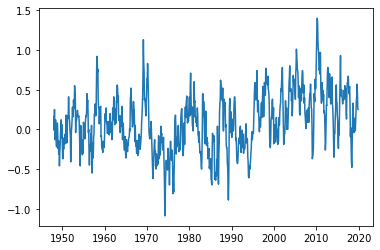

In [37]:
plt.plot(ds_tna['time'],ds_tna['tna'])

#### Composite Prep
Now we need to prepare our data to go into our composite

In [38]:
#AVISO is newer data so we should slice the TNA data to match the same times
ds_tna=ds_tna.sel(time=slice(ds_aviso['time'][0],ds_aviso['time'][-1]))
ds_tna

<xarray.Dataset>
Dimensions:  (time: 276)
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2015-12-01
Data variables:
    tna      (time) float64 -0.25 -0.25 -0.23 -0.07 ... 0.72 0.93 0.49 0.42

In [43]:
#Group monthly
ds_tna = ds_tna['tna'].resample(time="1MS").mean(dim="time")
ds_tna

<xarray.DataArray 'tna' (time: 276)>
array([-0.25, -0.25, -0.23, -0.07, -0.04,  0.07, -0.17, -0.11, -0.12,
       -0.13, -0.34, -0.41, -0.59, -0.61, -0.6 , -0.46, -0.5 , -0.43,
       -0.39, -0.29, -0.24, -0.08, -0.03, -0.13, -0.05, -0.04, -0.05,
        0.11,  0.3 ,  0.48,  0.58,  0.59,  0.4 ,  0.37,  0.51,  0.47,
        0.74,  0.4 ,  0.22,  0.31,  0.36,  0.18,  0.12, -0.03,  0.15,
        0.08,  0.03,  0.14,  0.31,  0.34,  0.15,  0.27,  0.43,  0.54,
        0.34,  0.16,  0.26,  0.59,  0.58,  0.44,  0.43,  0.77,  0.75,
        0.59,  0.59,  0.66,  0.56,  0.67,  0.51,  0.49,  0.43,  0.29,
       -0.1 , -0.2 , -0.23, -0.13,  0.11,  0.15,  0.17,  0.34,  0.38,
        0.25,  0.13,  0.27, -0.18, -0.1 ,  0.06, -0.01, -0.06, -0.16,
        0.01,  0.15,  0.02,  0.  , -0.12, -0.19, -0.13, -0.15,  0.15,
        0.05,  0.06,  0.24,  0.3 ,  0.34,  0.51,  0.48,  0.62,  0.66,
        0.78,  0.53,  0.37, -0.02, -0.19, -0.13, -0.06, -0.05,  0.07,
        0.36,  0.22,  0.2 ,  0.27,  0.  ,  0.04,  0.  ,  0.06,  0.22,
        0.36,  0.59,  0.66,  0.8 ,  0.48,  0.49,  0.5 ,  0.51,  0.36,
        0.46,  0.17,  0.27,  0.46,  0.68,  0.59,  0.62,  0.63,  0.53,
        0.46,  0.38,  0.68,  0.81,  1.01,  0.92,  0.84,  0.74,  0.73,
        0.54,  0.4 ,  0.55,  0.41,  0.19,  0.18,  0.41,  0.43,  0.52,
        0.36,  0.53,  0.69,  0.74,  0.71,  0.47,  0.46,  0.56,  0.33,
        0.4 ,  0.21,  0.16,  0.09,  0.01,  0.11,  0.24,  0.24,  0.09,
        0.14,  0.18,  0.27,  0.09,  0.28,  0.39,  0.45,  0.45,  0.57,
        0.43,  0.27,  0.26,  0.07, -0.37, -0.34, -0.31, -0.23,  0.05,
        0.45,  0.41,  0.35,  0.63,  0.51,  0.54,  0.8 ,  1.07,  1.27,
        1.4 ,  1.35,  1.11,  1.01,  0.97,  0.75,  0.77,  0.7 ,  0.96,
        0.97,  0.53,  0.41,  0.33,  0.41,  0.59,  0.43,  0.49,  0.36,
        0.44,  0.21,  0.23,  0.16, -0.02, -0.26, -0.17,  0.09,  0.31,
        0.3 ,  0.52,  0.72,  0.78,  0.75,  0.55,  0.44,  0.4 ,  0.7 ,
        0.53,  0.64,  0.32,  0.34,  0.56,  0.61,  0.66,  0.32,  0.27,
        0.13, -0.08, -0.35, -0.21, -0.06, -0.05,  0.14,  0.23,  0.51,
        0.56,  0.35,  0.34,  0.17,  0.11, -0.11, -0.24,  0.08, -0.07,
        0.16,  0.43,  0.72,  0.93,  0.49,  0.42])
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2015-12-01

<div class="alert alert-block alert-info">
Anomolies of AVISO Altimetry data
</div>

In [39]:
#Break up the calculation to make the memory strain easier
ds_climo = ds_aviso.groupby('time.month').mean()
ds_climo

<xarray.Dataset>
Dimensions:    (latitude: 121, longitude: 1440, month: 12)
Coordinates:
  * longitude  (longitude) float32 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * latitude   (latitude) float32 -14.88 -14.62 -14.38 ... 14.62 14.88 15.12
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sla        (month, latitude, longitude) float64 0.03086 0.03214 ... nan nan
    adt        (month, latitude, longitude) float64 0.2697 0.2698 ... nan nan

In [40]:
ds_slim = ds_aviso['sla'].resample(time="1MS").mean(dim="time")
ds_slim

<xarray.DataArray 'sla' (time: 276, latitude: 121, longitude: 1440)>
array([[[0.01837419, 0.01776774, 0.01645484, ..., 0.02223871,
         0.02038065, 0.01897419],
        [0.01460323, 0.01362903, 0.01197742, ..., 0.01754839,
         0.01643871, 0.01534194],
        [0.00934194, 0.00780968, 0.00577742, ..., 0.01057742,
         0.0107    , 0.01020645],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[0.027325  , 0.02663214, 0.02729643, ..., 0.03831429,
         0.03364643, 0.02975   ],
        [0.02244286, 0.02328929, 0.02613929, ..., 0.03233571,
         0.02766429, 0.02403214],
        [0.01762857, 0.02029286, 0.02528214, ..., 0.02442857,
         0.02046071, 0.01785   ],
...
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[0.05908387, 0.06065806, 0.06270323, ..., 0.05775484,
         0.05775806, 0.05822903],
        [0.05747419, 0.05858387, 0.06028387, ..., 0.05713548,
         0.05681935, 0.05696452],
        [0.05597742, 0.05655161, 0.0576129 , ..., 0.05614194,
         0.0556871 , 0.05572258],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]])
Coordinates:
  * time       (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2015-12-01
  * longitude  (longitude) float32 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * latitude   (latitude) float32 -14.88 -14.62 -14.38 ... 14.62 14.88 15.12

In [41]:
ds_anoms=ds_slim-ds_climo
ds_anoms

<xarray.Dataset>
Dimensions:    (latitude: 121, longitude: 1440, month: 12, time: 276)
Coordinates:
  * longitude  (longitude) float32 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * latitude   (latitude) float32 -14.88 -14.62 -14.38 ... 14.62 14.88 15.12
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * time       (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2015-12-01
Data variables:
    sla        (time, latitude, longitude, month) float64 -0.01249 ... nan
    adt        (time, latitude, longitude, month) float64 -0.2513 ... nan

#### Composite Time

In [45]:
tna_sla=ds_anoms.sel(time=ds_tna.dropna(dim='time')['time']).mean(dim='time')
print(tna_sla)

MemoryError: Unable to allocate 4.30 GiB for an array with shape (276, 121, 1440, 12) and data type float64